In [1]:
import pandas as pd
import numpy as np
import datetime
import vnquant.DataLoader as dl
import investpy
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
company_list = ['NT2','MSN','MBB']
num_of_shares = [300,100,300]

In [3]:
#stock data
def load_data(symbol):
    start = '2020-01-01'
    
    #you can fix the time frame by using timedelta function of datetime library
    now = datetime.datetime.now()
    end = now.strftime("%Y-%m-%d")
    loader = dl.DataLoader(symbol, start,end, data_source='VND', minimal=True)
    data = loader.download()
    close_data = data['close'].dropna()
#    data.reset_index()

    return data

#index data
def load_index_data(x):
    end = datetime.datetime.now()
    index =investpy.get_index_historical_data(x,country='vietnam',from_date='01/01/2019',to_date=end.strftime('%d/%m/%Y'))
    index = pd.DataFrame(index)
    index = index.drop(columns =['Currency'])
    index = index.reset_index()
    return index

In [4]:
d = {}
for name in company_list:
    d[name] = load_data(name)
    
data = d.copy()

2022-04-29 09:33:01,681 : INFO : data NT2 from 2020-01-01 to 2022-04-29 have already cloned!
2022-04-29 09:33:02,033 : INFO : data MSN from 2020-01-01 to 2022-04-29 have already cloned!
2022-04-29 09:33:02,434 : INFO : data MBB from 2020-01-01 to 2022-04-29 have already cloned!


In [5]:
#Slice to get needed data
for name in company_list:
    data[name]['Pctchange'] = data[name].close.pct_change()
    data[name] = data[name]['Pctchange'].values


#create dataframe from dictionary
df_change = pd.DataFrame({name:list(pct_change) for name,pct_change in data.items()})
df_change.dropna(inplace=True)
df_change = df_change.clip(lower=-0.07)
#df_change

In [6]:
corr = df_change.corr()
corr.style.background_gradient(cmap='BrBG_r')

,NT2,MSN,MBB
NT2,1.000000,0.230745,0.311598
MSN,0.230745,1.000000,0.343619
MBB,0.311598,0.343619,1.000000


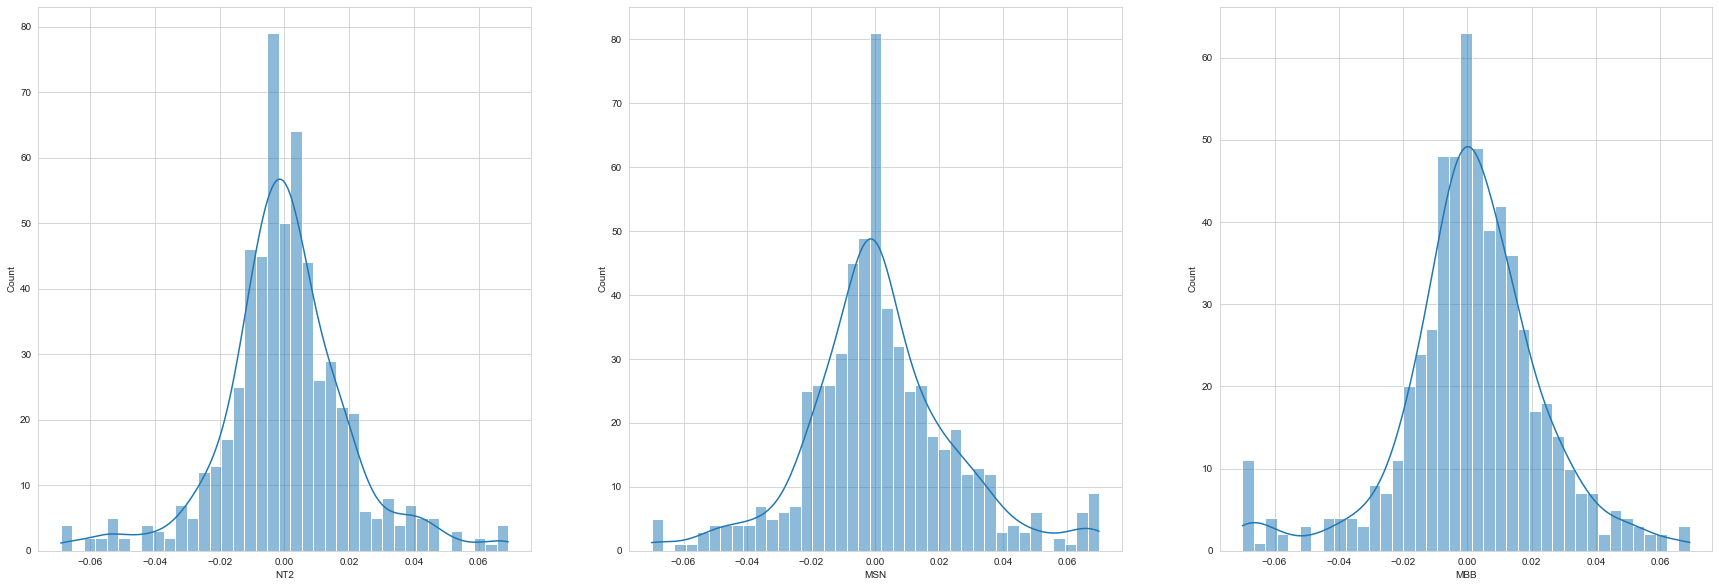

In [7]:
norm_cdf = pd.DataFrame()
# for name in company_list:
#     norm_cdf[name] = scipy.stats.norm.cdf(data[name]['close'])

fig,axes = plt.subplots(1,len(company_list),figsize=(30,10))
# for name in company_list:
#sns.displot(data = df_change)
# df_change.VCI

for name,x in zip(company_list,range(len(company_list))):
    sns.histplot(data = df_change[name],ax=axes[x],kde=True,bins=39)
    #sns.lineplot(x=df_change[name], y=norm_cdf[name], ax=axes[1,x])


<AxesSubplot:>

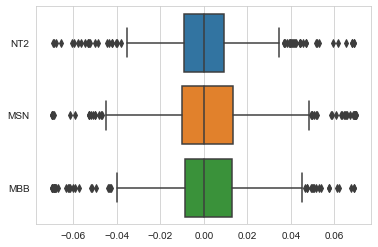

In [8]:
sns.boxplot(data = df_change,orient="h")

In [9]:
#sns.pairplot(df_change,kind='reg')

In [10]:
lastestPrice = pd.DataFrame(columns=['Lastest Price','Number of Shares','Weight'], index=company_list)
i=0
data =d.copy()
for name in company_list:
    x = float(data[name].close.iloc[-1].values)   
    lastestPrice['Lastest Price'].iloc[i] = x
    i+=1
    
lastestPrice['Number of Shares'] = num_of_shares
for i in range(len(company_list)):
    lastestPrice['Weight'].iloc[i] = round((lastestPrice['Number of Shares'].iloc[i]*lastestPrice['Lastest Price'].iloc[i])/sum(lastestPrice['Number of Shares']*lastestPrice['Lastest Price']),4)
#lastestPrice

/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
portfolio = pd.DataFrame(index = company_list, columns = ['Weight','Beta','Adjbeta','Std','AdjStd'])
portfolio.Weight = lastestPrice.Weight
portfolio

,Weight,Beta,Adjbeta,Std,AdjStd
NT2,0.2473,NaN,NaN,NaN,NaN
MSN,0.4276,NaN,NaN,NaN,NaN
MBB,0.3251,NaN,NaN,NaN,NaN


In [12]:
### Using the riskanalysis class from the risk analysis section
class risk_analysis(object):
    def __init__(self, stock_name, index_name, start_date):
        self.stock_name = stock_name
        self.index_name = index_name
        self.start_date = start_date



    def get_data_stock(self,stock_name, start_date):
        start_date = start_date
        end_date = datetime.datetime.today().strftime('%Y-%m-%d')
        loader = dl.DataLoader(stock_name , start_date, end_date, data_source='VND', minimal=True)
        data = loader.download()
        return data



    def get_index_data(self,index_name, start_date):
        start_date = datetime.datetime.strptime(start_date,'%Y-%m-%d').strftime('%d/%m/%Y')
        end_date = datetime.datetime.today().strftime('%d/%m/%Y')

        index = investpy.get_index_historical_data(index_name,country='vietnam',from_date=start_date,to_date=end_date)

        return index

    def data_collection(self):

        # Get index data
        index = self.get_index_data(self.index_name, self.start_date)
        index_data = index.reset_index()
        index_data = index_data.rename(columns={'Date':'date','Open':'open' ,'Close':'close','High':'high','Low':'low','Volume':'volume'})
        index_data['date'] = pd.to_datetime(index_data['date'])
        index_data = index_data.set_index('date')
        index_data = index_data.drop('Currency', axis=1)
        index_data['pctchange'] = index_data['close'].pct_change()
        index_data.dropna(inplace=True)


        # Get stock data
        stock = self.get_data_stock(self.stock_name, self.start_date)
        stock_data = stock.reset_index()
        stock_data = stock_data.rename(columns={'Date':'date', 'Close':'close'})
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data = stock_data.set_index('date')
        stock_data = stock_data[['open','high','low','close','volume']]
        stock_data['pctchange'] = stock_data['close'].pct_change()
        stock_data.dropna(inplace=True)

        self.index_data = index_data
        self.stock_data = stock_data

        return self.index_data, self.stock_data

    def calculate_std(self):
        index_data, stock_data = self.index_data, self.stock_data

        # Calculate variance
        #var_stock = round(float(['pctchange'].var()),5)
        # Calculate standard deviation
        def variance(data, ddof=0):
            n = len(data)
            mean = sum(data) / n

            return sum((x - mean) ** 2 for x in data) / (n - ddof)

        var_stock = round(variance(stock_data['pctchange']),5)
        var_stock = var_stock * 100

        stock_variance = 'Variance: ' + str(var_stock).format('.2f') + '%'

        std_stock = round(float(stock_data['pctchange'].std()),5)
        std_stock = std_stock * 100
        stock_std_deviation = 'Standard deviation: ' + str(std_stock).format('.2f') + '%'

        return std_stock

    def calculate_beta(self):
        index_data, stock_data = self.data_collection()

        # Calculate beta
        def beta(data, data_index):
            return np.cov(data, data_index)[0, 1] / np.var(data_index)

        beta_stock = beta(stock_data['pctchange'], index_data['pctchange'])
        beta_stock = round(beta_stock,5)

  

        return beta_stock

    def calculate_alpha(self):
        index_data, stock_data = self.data_collection()
        def beta(data, data_index):
            return np.cov(data, data_index)[0, 1] / np.var(data_index)

        # Calculate alpha
        def alpha(data, data_index):
            return np.mean(data) - beta(data, data_index) * np.mean(data_index)

        alpha_stock = alpha(stock_data['pctchange'], index_data['pctchange'])
        alpha_stock = round(alpha_stock,5) *100

        stock_alpha = 'Alpha: ' + str(alpha_stock).format('.2f') + '%'

        return alpha_stock

    def calculate_rsquared(self):
        index_data, stock_data = self.data_collection()

        # Calculate rsquared
        def rsquared(data, data_index):
            return 1 - (np.var(data) / np.var(data_index))

        rsquared_stock = rsquared(stock_data['pctchange'], index_data['pctchange'])
        rsquared_stock = round(rsquared_stock,5)

        stock_rsquared = 'Rsquared: ' + str(rsquared_stock).format('.2f')

        return rsquared_stock

    def calculate_correlation(self):
        index_data, stock_data = self.data_collection()

        # Calculate correlation
        def correlation(data, data_index):
            return np.corrcoef(data, data_index)[0, 1]

        correlation_stock = correlation(stock_data['pctchange'], index_data['pctchange'])
        correlation_stock = round(correlation_stock,5)

        stock_correlation = 'Correlation: ' + str(correlation_stock).format('.2f')

        return correlation_stock

In [13]:
#Collecting data and calculate beta for each symbol
index = 'VN'
start = '2020-01-01' 
#create dictionary for company's beta
Risk_indicator = {}
for name in company_list:
    company = risk_analysis(name,index, start)
    beta = float(company.calculate_beta())
    std = float(company.calculate_std())
    Risk_indicator[name] = beta  ,std
x = Risk_indicator.copy()
df_risk = pd.DataFrame.from_dict(Risk_indicator,orient='index',columns=['Beta','Std'])
df_risk

2022-04-29 09:33:04,439 : INFO : data NT2 from 2020-01-01 to 2022-04-29 have already cloned!
2022-04-29 09:33:05,070 : INFO : data MSN from 2020-01-01 to 2022-04-29 have already cloned!
2022-04-29 09:33:05,932 : INFO : data MBB from 2020-01-01 to 2022-04-29 have already cloned!


,Beta,Std
NT2,0.70250,1.984
MSN,0.92902,2.398
MBB,1.33747,2.520


In [14]:
portfolio['Beta'] = df_risk.Beta.values
portfolio['Adjbeta'] = portfolio['Beta']*portfolio['Weight']
portfolio['Std'] = df_risk.Std.values
portfolio['AdjStd'] = portfolio['Std']*portfolio['Weight']
portfolio

,Weight,Beta,Adjbeta,Std,AdjStd
NT2,0.2473,0.70250,0.173728,1.984,0.490643
MSN,0.4276,0.92902,0.397249,2.398,1.025385
MBB,0.3251,1.33747,0.434811,2.520,0.819252


In [15]:
portfolio_beta = round(portfolio['Adjbeta'].sum(),4)
portfolio_std = round(portfolio['AdjStd'].sum(),4)
print('Portfolio beta: '+str(portfolio_beta).format('.2f'))
print('Portfolio standard deviation:'+str(portfolio_std).format('.2f') + '%')

Portfolio beta: 1.0058
Portfolio standard deviation:2.3353%


## Value at Risk (VaR)

In [16]:
returns = df_change
returns.dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
returns['portfolio'] = returns.dot(portfolio.Weight)

In [17]:
# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")
        
def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")


In [18]:
from scipy.stats import norm,t

def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR


def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [19]:
port_return, port_std = portfolioPerformance(portfolio.Weight,mean_returns,cov_matrix,365)
var_parametric(port_return,port_std,distribution='normal')

0.07223628287620376

In [20]:
cvar_parametric(port_return,port_std)


0.2029486185795374

In [28]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR {} VND'.format(round(VaR,2)))
print('CVaR {} VND'.format(round(CVaR,2)))

VaR 10165703.07VND
CVaR 15964723.69VND


In [30]:
# Monte Carlo Method
mc_sims = 300 # number of simulations
T = 252 #timeframe in days

meanM = np.full(shape=(T, len(portfolio.Weight)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 100000000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(portfolio.Weight)))
    L = np.linalg.cholesky(cov_matrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(portfolio.Weight, dailyReturns.T)+1)*initialPortfolio

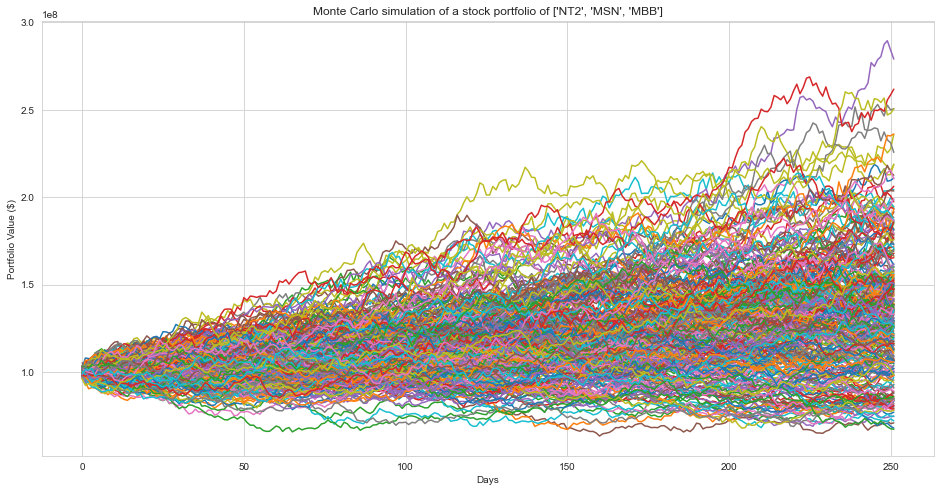

In [31]:
fig,axes = plt.subplots(1,1,figsize = (16,8))
fig = plt.plot(portfolio_sims)
axes.set_xlabel('Days')
axes.set_ylabel('Portfolio Value ($)')
axes = plt.title('Monte Carlo simulation of a stock portfolio of ' + str(company_list))
plt.show()

In [24]:
import vnquant.DataLoader as dl
import pandas as pd
import numpy as np
import datetime
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply
from backtesting.test import SMA


/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [201]:
def load_stock_data(symbol):
    start = '2020-01-01'
    
    #you can fix the time frame by using timedelta function of datetime library
    now = datetime.datetime.now()
    end = now.strftime("%Y-%m-%d")
    loader = dl.DataLoader(symbol, start,end, data_source='VND', minimal=True)
    pricedata = loader.download()
    
    #format the data for the mplfinance
    stock = pricedata.copy()
    stock.reset_index(inplace = True)

    dailyInfo = pd.DataFrame( columns =['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    dailyInfo['Date'] = stock['date']
    dailyInfo['Open'] = stock['open']
    dailyInfo['High'] = stock['high']
    dailyInfo['Low'] = stock['low']
    dailyInfo['Close'] = stock['close']
    dailyInfo['Volume'] = stock['volume']
    dailyInfo.set_index('Date', inplace= True)
    
    #to store data remove the '#' on the following line
    #csv_file = close_data.to_csv(f'Data/ClosePrice/{symbol} historical since {start}', index=True)

    return dailyInfo

In [202]:
#Simple backtesting using backtesting.py
#simple sma backtest
for name in company_list:
    stock = load_stock_data(name)
    
        #Bollinger band
    def BBupper(array,n):
        B_MA = pd.Series(array).rolling(n).mean()
        sigma = pd.Series(array).rolling(n).std() 

        BU = pd.Series((B_MA + 2 * sigma), name='BU')
        return BU

    def BBlower(array,n):
        B_MA = pd.Series(array).rolling(n).mean()
        sigma = pd.Series(array).rolling(n).std() 

        BL = pd.Series((B_MA - 2 * sigma), name='BL')    
        return BL


    class SmaCross(Strategy):
        n1 = 20
        n2 = 60

        def init(self):
            close = self.data.Close
            self.sma1 = self.I(SMA, close, self.n1)
            self.sma2 = self.I(SMA, close, self.n2)
            self.upperband = self.I(BBupper, close, 20)
            self.lowerband = self.I(BBlower, close, 20)

        def next(self):
            if crossover(self.sma1, self.sma2):
                self.buy()
            elif crossover(self.sma2, self.sma1):
                self.sell()


    bt = Backtest(stock, SmaCross,
                  cash=10000, commission=.007,
                  exclusive_orders=True)

    output = bt.run()
    bt.plot()

2022-04-28 19:35:40,905 : INFO : data NT2 from 2020-01-01 to 2022-04-28 have already cloned!


2022-04-28 19:35:41,816 : INFO : data MSN from 2020-01-01 to 2022-04-28 have already cloned!


2022-04-28 19:35:43,129 : INFO : data MBB from 2020-01-01 to 2022-04-28 have already cloned!


In [21]:
#backtesting sma and rsi

def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

#Bollinger band
def BBupper(array,n):
    B_MA = pd.Series(array).rolling(n).mean()
    sigma = pd.Series(array).rolling(n).std() 
    
    BU = pd.Series((B_MA + 2 * sigma), name='BU')
    return BU

def BBlower(array,n):
    B_MA = pd.Series(array).rolling(n).mean()
    sigma = pd.Series(array).rolling(n).std() 
    
    BL = pd.Series((B_MA - 2 * sigma), name='BL')    
    return BL

for name in company_list:
    stock = load_stock_data(name)
    class System(Strategy):
        d_rsi = 30  # Daily RSI lookback periods
        w_rsi = 30  # Weekly
        level = 70

        def init(self):
            # Compute moving averages the strategy demands
            self.ma10 = self.I(SMA, self.data.Close, 10)
            self.ma20 = self.I(SMA, self.data.Close, 20)
            self.ma50 = self.I(SMA, self.data.Close, 50)
            self.ma100 = self.I(SMA, self.data.Close, 100)

            # Compute daily RSI(30)
            self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)

            # To construct weekly RSI, we can use `resample_apply()`
            # helper function from the library
            self.weekly_rsi = resample_apply(
                'W-FRI', RSI, self.data.Close, self.w_rsi)
            
            #Bollingerband
            self.upperband = self.I(BBupper, self.data.Close, 20)
            self.lowerband = self.I(BBlower, self.data.Close, 20)

        def next(self):
            price = self.data.Close[-1]

            # If we don't already have a position, and
            # if all conditions are satisfied, enter long.
            if (not self.position and
                self.daily_rsi[-1] > self.level and
                self.weekly_rsi[-1] > self.level and
                self.weekly_rsi[-1] > self.daily_rsi[-1] and
                self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
                price > self.ma10[-1]):

                # Buy at market price on next open, but do
                # set 8% fixed stop loss.
                self.buy(sl=.92 * price)

            # If the price closes 2% or more below 10-day MA
            # close the position, if any.
            elif price < .98 * self.ma10[-1]:
                self.position.close()


    backtest = Backtest(stock, System, commission=.002)
    backtest.run()



    backtest.optimize(d_rsi=range(10, 35, 5),
                      w_rsi=range(10, 35, 5),
                      level=range(30, 80, 10))

    backtest.plot()
    #print(backtest)

2022-04-28 11:48:44,347 : INFO : data NT2 from 2020-01-01 to 2022-04-28 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


2022-04-28 11:48:48,775 : INFO : data FPT from 2020-01-01 to 2022-04-28 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


2022-04-28 11:48:53,914 : INFO : data MBB from 2020-01-01 to 2022-04-28 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


2022-04-28 11:48:58,325 : INFO : data HSG from 2020-01-01 to 2022-04-28 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [22]:
company_list


['NT2', 'FPT', 'MBB', 'HSG']

In [23]:
d = {}
for name in company_list:
    d[name] = load_data(name)
    
x = d.copy()

2022-04-25 19:19:05,670 : INFO : data NT2 from 2020-01-01 to 2022-04-25 have already cloned!
2022-04-25 19:19:06,408 : INFO : data FPT from 2020-01-01 to 2022-04-25 have already cloned!
2022-04-25 19:19:07,101 : INFO : data MBB from 2020-01-01 to 2022-04-25 have already cloned!
2022-04-25 19:19:07,760 : INFO : data HSG from 2020-01-01 to 2022-04-25 have already cloned!


In [24]:
for name in company_list:
    x[name]['Pctchange'] = x[name].close.pct_change()
    x[name]['Cum_return'] = (d[name]['Pctchange'] + 1).cumprod()
    x[name].dropna(inplace=True)


In [25]:
cum_returns = {}
for name in company_list:
    cum_returns[name]= x[name]['Cum_return']
    
cum_returns = pd.DataFrame.from_dict(cum_returns)
print(cum_returns)
for name in company_list:
    cum_returns[name] = portfolio['Weight'][name] *cum_returns[name]

cum_returns['Portfolio'] =  cum_returns.sum(axis = 1)
cum_returns = pd.DataFrame(cum_returns['Portfolio'])


                 NT2       FPT       MBB       HSG
date                                              
2020-01-03  0.986207  0.982935  1.002358  0.974359
2020-01-06  0.983908  0.972696  0.988208  0.979243
2020-01-07  0.983908  0.991468  0.990566  0.968254
2020-01-08  0.942529  0.969283  0.976415  0.960928
2020-01-09  0.910345  0.982935  0.992925  0.987790
...              ...       ...       ...       ...
2022-04-19  1.117241  1.911263  1.382075  3.699634
2022-04-20  1.110345  1.911263  1.391509  3.675214
2022-04-21  1.062069  1.911263  1.415094  3.675214
2022-04-22  1.034483  1.895904  1.415094  3.687424
2022-04-25  0.963218  1.764505  1.325472  3.431013

[575 rows x 4 columns]


In [26]:
index = load_index_data('VN')
index['Pctchange'] = index.Close.pct_change()
index['Cum_return'] = (index['Pctchange'] + 1).cumprod()
index.dropna(inplace=True)
index_cum = index.Cum_return
#cum_returns['index'] = index_cum.values
cum_returns['index'] = index_cum.values

ValueError: Length of values (825) does not match length of index (575)

In [ ]:
cum_returns.reset_index(inplace=True)

In [ ]:
import pandas as pd
import vnquant.DataLoader as dl
import datetime
import investpy
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

fig = px.line(cum_returns, x="date", y=cum_returns.columns,hover_data={"date": "|%B %d, %Y"})
fig.update_xaxes(dtick="M1",
        tickformat="%b\n%Y",
        ticklabelmode="period"
        )
fig.show()

### Monte carlo simulation

In [125]:
Dict = {}
data =d.copy()
for name in company_list:
    data[name]=data[name].close
df = pd.DataFrame.from_dict(Dict)

In [126]:
df

""
